# Introduction to SolGen 
The SolGen package is a hierarchical simulation tool for photonic circuit. This notebook will cover the basic structure and the usage of the standalone package. Note that the syntax and logic is mainly built to imitate the Nazca Design structure. 

## Guide by examples
### Getting started: a simple straight waveguide
Lets start with a very simple example, the transmission trough a straight waveguide. Although quite simple, this allows for some clear illustration if the code. 

In [1]:
import solver as sv

with sv.Solver() as mainsol:
    WG=sv.Waveguide(L=10.0, n=2.5)
    wg=WG.put()
    
    sv.Pin('a0').put(wg.pin['a0'])
    sv.Pin('b0').put(wg.pin['b0'])

With this code the main building block for realizing a simulation are put in place. In details:
1. A simulation cell mainsol is created (a solver object, in the syntax of the package).
2. A waveguide object (WG) with length 10 um and effective index 2.5 is created. At this point the simulation is still empty, since the model of the waveguide has been created but not placed. The package provides a few pre-defined models. Each models represent a component with a defined set of ports, indicated as named pin. In the case of the waveguide, the model has 2 ports, called a0 and b0.
3. The waveguide model is placed inside the simulation region with a put statement. This creates the instance (terminology borrowed form Nazca) wg. Since this is the first instance placed, the put is called with no argument. 
4. In order to be able to extract meaningful data from the simulation, the external ports should be defined. I this case, since only one waveguide is present, the two ports of the simulation coincide with the waveguide's ports.

In order to run the simulation and obtain data, a few more passage are needed:

In [2]:
MOD=mainsol.solve(wl=1.55)
T=MOD.get_T('a0','b0')
P=MOD.get_PH('a0','b0')
print(f'{T:.6} {P:.6}')

1.0 0.810734


The simulation is run by calling the method solve on the solver object. The input of the method can be a variable number of parameters previously defined. The parameter wl, which stands for wavelegnth, is defined for almost every model. 
The output of the solve method is a model object containing the scattering matrix of the defined system. 
Information about the transmission or reflection can be extracted with the dedicated methods `get_T` and `get_PH`. Both methods takes as input the names of two ports and yields the absolute transmission and the phase, respectively. 
In this case, we find that the transmission of a straight lossless waveguide is 1.0 (surprise!) and the phase acquired is 0.81 rad (modulus 2 pi, pretty meaningless in this case).

A more complete simulation could involve a wavelength sweep. This has to be done manually using a for loop:

Text(0.5, 1.0, 'Phase')

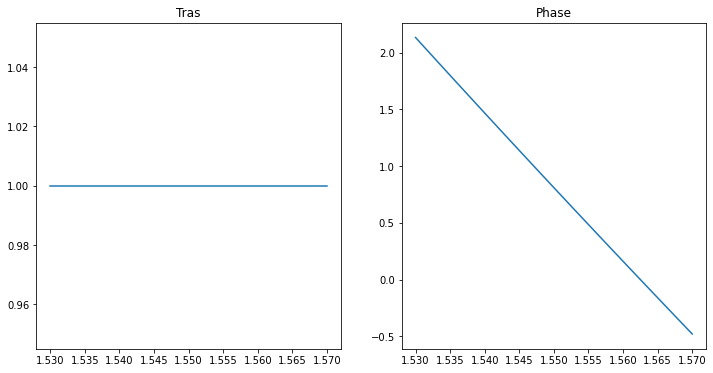

In [3]:
import numpy as np
import matplotlib.pyplot as plt

wl_list=np.linspace(1.53,1.57,101)
Tlist, Plist = [], []
for wl in wl_list:
    MOD=mainsol.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Plist.append(MOD.get_PH('a0','b0'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12.0, 6.0])    
ax1.plot(wl_list, Tlist)
ax1.set_title('Tras')
ax2.plot(wl_list, Plist)
ax2.set_title('Phase')


Off course, a simulation with only one components inside is not very meaningful. In order to add more components and connect them, we will pass some additional parameters to the put statement. Here is the update example:

In [4]:
with sv.Solver() as mainsol:
    WG=sv.Waveguide(L=10.0, n=2.5)
    wg1=WG.put()
    wg2=WG.put('a0',wg1.pin['b0'])
    
    sv.Pin('a0').put(wg1.pin['a0'])
    sv.Pin('b0').put(wg2.pin['b0'])
    
mainsol.show_connections()
mainsol.show_free_pins()

Connection of solver:                 Solver object (id=140706925047088))
(Structure (id=140706925044792) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706925043952),    a0) <--> (Structure (id=140706925045240) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706925047704),    b0)

Free pins of solver:                 Solver object (id=140706925047088))
(Structure (id=140706925045240) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706925047704),    a0) -->    a0
(Structure (id=140706925044792) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706925043952),    b0) -->    b0



In this case the second put statement add a new instance of the same waveguide, and connect the pin 'a0' of the new instance with the pin 'b0' of the already placed one. 
Rerunning the sweep thus results in:

Text(0.5, 1.0, 'Phase')

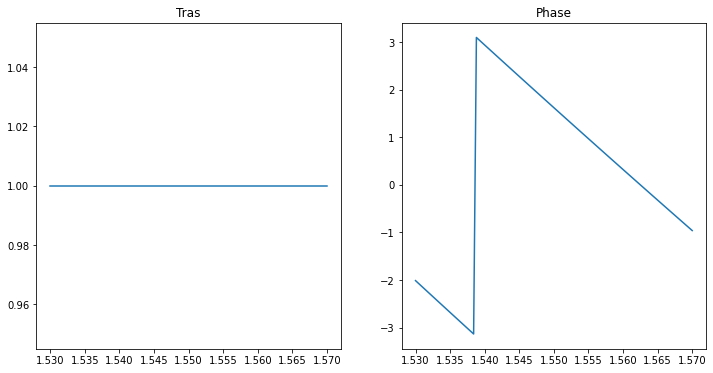

In [5]:
Tlist, Plist = [], []
for wl in wl_list:
    MOD=mainsol.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Plist.append(MOD.get_PH('a0','b0'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12.0, 6.0])    
ax1.plot(wl_list, Tlist)
ax1.set_title('Tras')
ax2.plot(wl_list, Plist)
ax2.set_title('Phase')

As can be seen, the transmission is still 1, while the phase evolution is steeper, as expected from a longer waveguide. 

### Adding more: Add-Drop filter
As a second example, let's tackle something more meaningful: and add-drop filter based on ring resonator. For this, we will make use of another available model in the GenSol package: the directional coupler, our first 4 ports device.

For reason that will be apparent in the future, we will wrap the generation of the solver object inside a function. 

In [6]:
wl_list=np.linspace(1.53,1.57,201)

def add_drop(R,n,CR):
    with sv.Solver() as ADD_DROP:
        WG=sv.Waveguide(L=np.pi*R, n=n)
        BM=sv.GeneralBeamSplitter(ratio=CR)
        
        bm1=BM.put()
        wg1=WG.put('a0',bm1.pin['b1'])
        bm2=BM.put('b1',wg1.pin['b0'])
        wg2=WG.put('a0',bm2.pin['a1'])
        
        sv.connect(wg2.pin['b0'],bm1.pin['a1'])
        
        sv.Pin('a0').put(bm1.pin['a0'])
        sv.Pin('b0').put(bm1.pin['b0'])
        sv.Pin('a1').put(bm2.pin['a0'])
        sv.Pin('b1').put(bm2.pin['b0'])
    return ADD_DROP
        
ADD_DROP=add_drop(10.0, 2.5, 0.5)      

This simulation used 2 models. The first is the familiar waveguide. The other is a standard directional coupler, a four port (a0,a1,b0,b1) device. The light entering one the the a(b) port is split between the b(a) ports with a ratio defined at the creation of the model (default is 50/50).

A new function, namely the `connect`, is also used. This makes the connection between pins of already placed instances, which is useful when an instance has to be connected to more than one instance. 

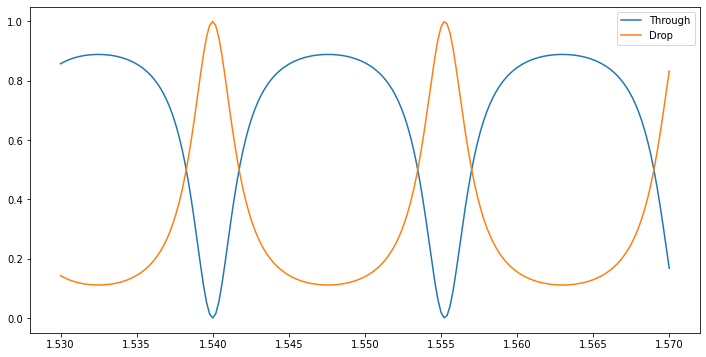

In [7]:
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend()

Now, by wrapping the definition of the add-drop inside a function, it is straightforward to change some parameters. For example, we could increase the radius.

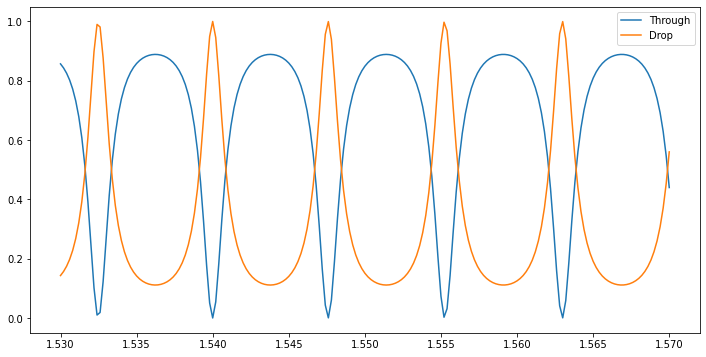

In [8]:
ADD_DROP=add_drop(20.0, 2.5, 0.5)  
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend()

Which leads to a decrease of the Free Spectral Range. Or, we could decrease the coupling ratio of the DC coupler from 50/50 to 10/90

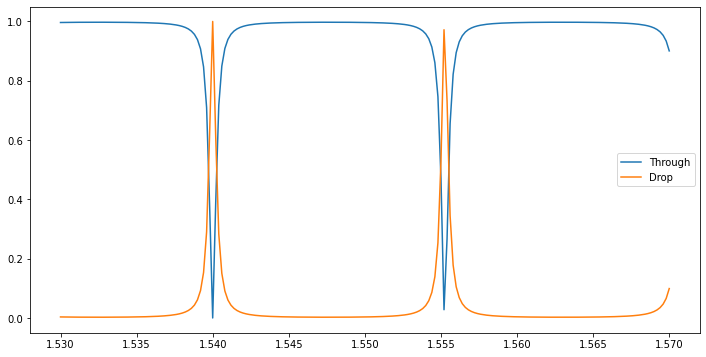

In [9]:
ADD_DROP=add_drop(10.0, 2.5, 0.1)  
Tlist, Dlist = [], []
for wl in wl_list:
    MOD=ADD_DROP.solve(wl=wl)
    Tlist.append(MOD.get_T('a0','b0'))
    Dlist.append(MOD.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, Tlist, label='Through')
plt.plot(wl_list, Dlist, label='Drop')
plt.legend()

which reduces the width of the resonance. 

### Going full power: Hierarchical design
An interesting features of the GenSol package is that the cells generated by the `with Solver` statement can be inserted as models in newly defined cells.

For example it would be really easy to define filter based on a double ring by reusing the function created for the single add-drop.

To do this, firstly we need to define two add-drop with different radii (for completeness, the spectra of the drop channels will also be plotted):



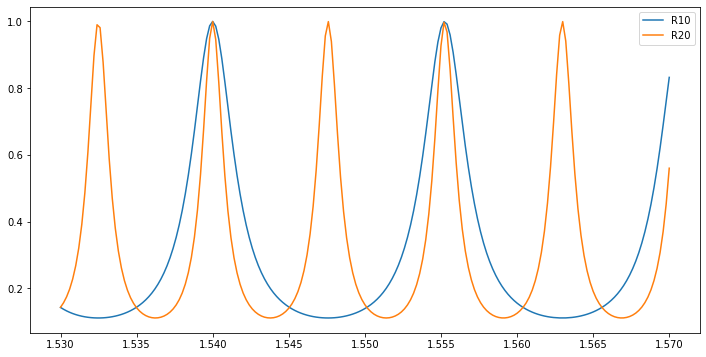

In [10]:
ADD_DROP_R10=add_drop(10.0, 2.5, 0.5)  
ADD_DROP_R20=add_drop(20.0, 2.5, 0.5)

D10list, D20list = [], []
for wl in wl_list:
    MOD10=ADD_DROP_R10.solve(wl=wl)
    MOD20=ADD_DROP_R20.solve(wl=wl)

    D10list.append(MOD10.get_T('a0','a1'))
    D20list.append(MOD20.get_T('a0','a1'))

plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, D10list, label='R10')
plt.plot(wl_list, D20list, label='R20')
plt.legend()


Then, we define a new solver and we use the previosly defined ones as building blocks:

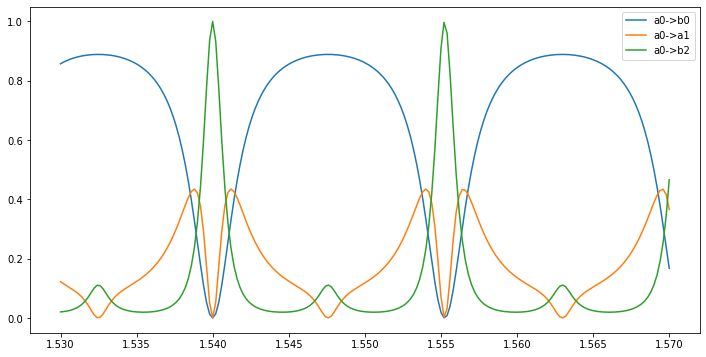

In [11]:
with sv.Solver() as FILTER:
    r1=ADD_DROP_R10.put()
    r2=ADD_DROP_R20.put('b0',r1.pin['a1'])
    
    sv.Pin('a0').put(r1.pin['a0'])
    sv.Pin('a1').put(r2.pin['a0'])
    sv.Pin('a2').put(r2.pin['a1'])
    sv.Pin('b0').put(r1.pin['b0'])
    sv.Pin('b1').put(r1.pin['b1'])
    sv.Pin('b2').put(r2.pin['b1'])
    
b0l,a1l,b2l=[], [], []
for wl in wl_list:
    MOD=FILTER.solve(wl=wl)

    b0l.append(MOD.get_T('a0','b0'))
    a1l.append(MOD.get_T('a0','a1'))
    b2l.append(MOD.get_T('a0','b2'))
    
plt.figure(figsize=[12.0, 6.0])    
plt.plot(wl_list, b0l, label='a0->b0')
plt.plot(wl_list, a1l, label='a0->a1')
plt.plot(wl_list, b2l, label='a0->b2')
plt.legend()


### Additional feature: parametric blocks
Sometimes, it would be nicer to change some parameter of the simulation without redefine the entire cell. This is achieved by using parametric models. One great example of that is a model for the Phase Shifter. It is a simple 2 ports components which can apply variable phase shift (measured in pi units).

We will employ this phase shifter inside a MZM:

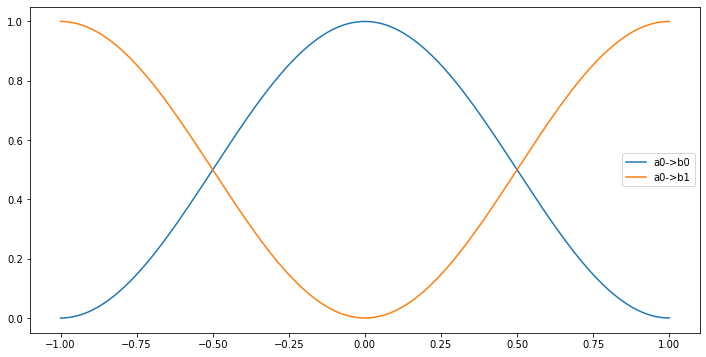

In [12]:
with sv.Solver() as MZM:
    WG=sv.Waveguide(L=10.0, n=2.5)
    BM=sv.GeneralBeamSplitter(ratio=0.5)
    PS=sv.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    ps =PS.put('a0',wg1.pin['b0'])
    bm2=BM.put('a0',ps.pin['b0'])

    sv.connect(wg2.pin['b0'],bm2.pin['a1'])
    
    sv.Pin('a0').put(bm1.pin['a0'])
    sv.Pin('a1').put(bm1.pin['a1'])
    sv.Pin('b0').put(bm2.pin['b0'])
    sv.Pin('b1').put(bm2.pin['b1'])
    
b0l,b1l = [], []
psl=np.linspace(-1.0,1.0,201)  
for ps in psl:
    MOD=MZM.solve(wl=1.55,PS=ps)
    b0l.append(MOD.get_T('a0','b0'))
    b1l.append(MOD.get_T('a0','b1'))
    
plt.figure(figsize=[12.0, 6.0])    
plt.plot(psl, b0l, label='a0->b0')
plt.plot(psl, b1l, label='a0->b1')
plt.legend() 
    

Each parametric building block has his own name for the parameter.The same name (in the case of the Phase Shifter is 'PS' has to be passed to solve in order to be set). This creates a conflict when multiple parametric models are added with the same parameter name. In order to solve the problem, an option to map the parameters name to a new name is provided by the put statement. To rename the parameters of the model, a dictionary containing the name mapping (`{ oldname : newname}`) has to be provided in the put. This allows the independent control of each instance of a parametric model. 

A small note one the use of parameters in hierarchical simulation. It is better to think as the parameter name to be global variables. This because the same BB could be placed at different levels, and the mapping between parameter and component has to be unique. 

To illustrate this, here is an example of the same MZM, but with a phase shifter in each arm. In order the see the different effect due to the phase shifters in each arm, 

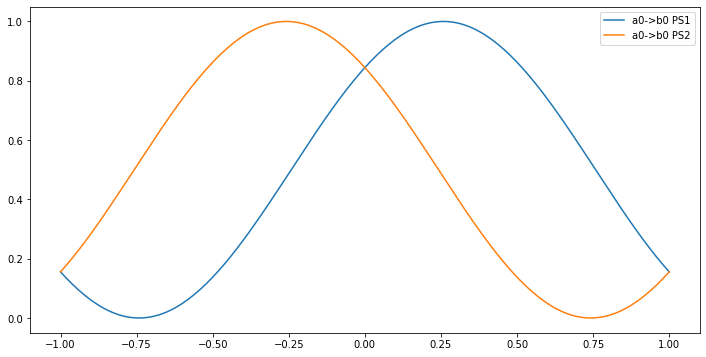

In [13]:
with sv.Solver() as MZM:
    WG=sv.Waveguide(L=10.0, n=2.5)
    BM=sv.GeneralBeamSplitter(ratio=0.5)
    PS=sv.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    wg2=WG.put('a0',wg2.pin['b0'])
    ps1 =PS.put('a0',wg1.pin['b0'],param_mapping={'PS': 'PS1'})
    ps2 =PS.put('a0',wg2.pin['b0'],param_mapping={'PS': 'PS2'})

    bm2=BM.put('a0',ps1.pin['b0'])
    sv.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    sv.Pin('a0').put(bm1.pin['a0'])
    sv.Pin('a1').put(bm1.pin['a1'])
    sv.Pin('b0').put(bm2.pin['b0'])
    sv.Pin('b1').put(bm2.pin['b1'])
   
psl=np.linspace(-1.0,1.0,201)  
Tl1,Tl2 = [], []
for ps in psl:
    MOD=MZM.solve(wl=1.55, PS1=ps, PS2=0.0)
    Tl1.append(MOD.get_T('a0','b0'))
    MOD=MZM.solve(wl=1.55, PS1=0.0, PS2=ps)
    Tl2.append(MOD.get_T('a0','b0'))
    
plt.figure(figsize=[12.0, 6.0])
plt.plot(psl, Tl1, label='a0->b0 PS1')
plt.plot(psl, Tl2, label='a0->b0 PS2')
plt.legend()

In the hierarchical simulation, the renaming of the parameters could be used at multiple levels, even on already mapped names. For example, we could reuse the model for the balanced modulator in order to simulate a more complex I/Q modulator. Note that in the following script the function `get_A` is used to get directly the complex amplitude of the transmission, since in a IQ modulator the phase of the output signal is as important as the amplitude. 

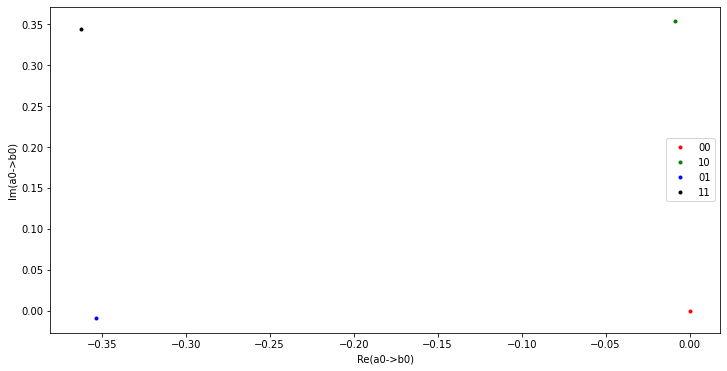

In [14]:
with sv.Solver(name='MZM') as MZM_bal:
    WG=sv.Waveguide(L=10.0, n=2.5)
    BM=sv.GeneralBeamSplitter(ratio=0.5)
    PS=sv.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    wg1=WG.put('a0',bm1.pin['b0'])
    wg2=WG.put('a0',bm1.pin['b1'])
    ps1 =PS.put('a0',wg1.pin['b0'],param_mapping={'PS': 'PS1'})
    ps2 =PS.put('a0',wg2.pin['b0'],param_mapping={'PS': 'PS2'})

    bm2=BM.put('a0',ps1.pin['b0'])
    sv.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    sv.Pin('a0').put(bm1.pin['a0'])
    sv.Pin('a1').put(bm1.pin['a1'])
    sv.Pin('b0').put(bm2.pin['b0'])
    sv.Pin('b1').put(bm2.pin['b1'])
    
with sv.Solver(name='IQ_mod') as IQ_mod:
    BM=sv.GeneralBeamSplitter(ratio=0.5)
    PS=sv.PhaseShifter(param_name='PS')
    
    bm1=BM.put()
    mz1=MZM_bal.put('a0',bm1.pin['b0'],param_mapping={'PS1' : 'I1', 'PS2' : 'I2'})
    mz2=MZM_bal.put('a0',bm1.pin['b1'],param_mapping={'PS1' : 'Q1', 'PS2' : 'Q2'})
    ps1=PS.put('a0',mz1.pin['b1'], param_mapping={'PS' : 'I'})
    ps2=PS.put('a0',mz2.pin['b1'], param_mapping={'PS' : 'Q'})
    bm2=BM.put('a0',ps1.pin['b0'])
    sv.connect(ps2.pin['b0'],bm2.pin['a1'])
    
    sv.Pin('a0').put(bm1.pin['a0'])
    sv.Pin('a1').put(bm1.pin['a1'])
    sv.Pin('b0').put(bm2.pin['b0'])
    sv.Pin('b1').put(bm2.pin['b1'])
    
    sv.Pin('DumIn0').put(mz1.pin['a1'])
    sv.Pin('DumIn1').put(mz2.pin['a1'])
    sv.Pin('DumOut0').put(mz1.pin['b0'])
    sv.Pin('DumOut1').put(mz2.pin['b0'])
    
#IQ_mod.show_connections()
#IQ_mod.show_free_pins()

plt.figure(figsize=[12.0, 6.0])

MOD=IQ_mod.solve(wl=1.55, I1=0.0, I2=0.0, Q1=0.0, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'r.',label='00')

MOD=IQ_mod.solve(wl=1.55, I1=0.5, I2=0.0, Q1=0.0, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'g.',label='10')

MOD=IQ_mod.solve(wl=1.55, I1=0.0, I2=0.0, Q1=0.5, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'b.',label='01')

MOD=IQ_mod.solve(wl=1.55, I1=0.5, I2=0.0, Q1=0.5, Q2=0.0, I=0.0, Q=0.5)
T=MOD.get_A('a0','b0')
plt.plot(T.real,T.imag,'k.',label='11')

plt.xlabel('Re(a0->b0)')
plt.ylabel('Im(a0->b0)')
plt.legend()
    

As can be seen, this renaming of parameters offers a pretty flexible and intuitive way of building up and controlling circuits with many parametric building blocks. 

### Easy sweep

Until now, every time a parametric sweep was needed, the loop and the plotting was performed manually. A much quicker way is provided by feeding into the `solve` method some array-like object (list or numpy array). The data can then be extracted with the method `get_data`, which, given two ports, returns a pandas DataFrame containing the values of all the parameters together with the transmission, phase and amplitude between the selected ports. Here is an example on the 'MZM' object:

       wl   PS1  PS2         T     Phase           Amplitude
0    1.55 -1.00  0.0  0.155517 -0.354696  0.369808-0.136962j
1    1.55 -0.99  0.0  0.144303 -0.338988  0.358255-0.126320j
2    1.55 -0.98  0.0  0.133441 -0.323280  0.346373-0.116047j
3    1.55 -0.97  0.0  0.122941 -0.307572  0.334175-0.106151j
4    1.55 -0.96  0.0  0.112813 -0.291864  0.321671-0.096644j
..    ...   ...  ...       ...       ...                 ...
196  1.55  0.96  0.0  0.203653 -0.417528  0.412512-0.182995j
197  1.55  0.97  0.0  0.191150 -0.401820  0.402384-0.170989j
198  1.55  0.98  0.0  0.178951 -0.386112  0.391883-0.159307j
199  1.55  0.99  0.0  0.167070 -0.370404  0.381021-0.147961j
200  1.55  1.00  0.0  0.155517 -0.354696  0.369808-0.136962j

[201 rows x 6 columns]


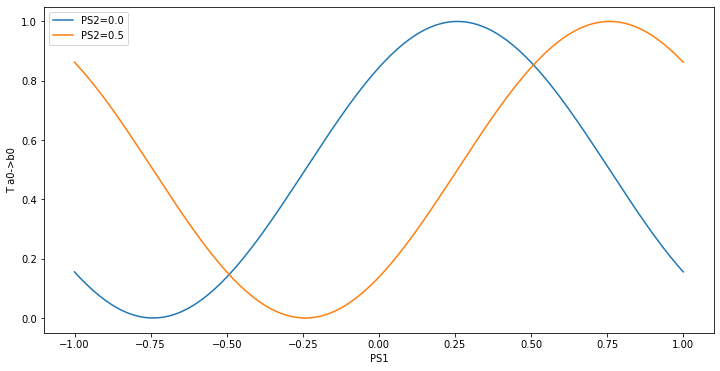

In [15]:
plt.figure(figsize=[12.0, 6.0])

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=0.0).get_data('a0','b0')
print(T)
plt.plot(T['PS1'],T['T'],label='PS2=0.0')

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=0.5).get_data('a0','b0')
plt.plot(T['PS1'],T['T'],label='PS2=0.5')

plt.xlabel('PS1')
plt.ylabel('T a0->b0')
plt.legend()

More than a parameter can be an array in one single solve call. Since all array parameters are looped together, every array-like parameter needs to have the same shape. Here is an example:

       wl   PS1   PS2         T   Phase           Amplitude
0    1.55 -1.00  1.00  0.844483  1.2161  0.319159+0.861755j
1    1.55 -0.99  0.99  0.866559  1.2161  0.323303+0.872945j
2    1.55 -0.98  0.98  0.887187  1.2161  0.327129+0.883275j
3    1.55 -0.97  0.97  0.906288  1.2161  0.330632+0.892732j
4    1.55 -0.96  0.96  0.923785  1.2161  0.333808+0.901309j
..    ...   ...   ...       ...     ...                 ...
196  1.55  0.96 -0.96  0.743537  1.2161  0.299476+0.808610j
197  1.55  0.97 -0.97  0.770475  1.2161  0.304853+0.823128j
198  1.55  0.98 -0.98  0.796347  1.2161  0.309929+0.836834j
199  1.55  0.99 -0.99  0.821049  1.2161  0.314699+0.849713j
200  1.55  1.00 -1.00  0.844483  1.2161  0.319159+0.861755j

[201 rows x 6 columns]


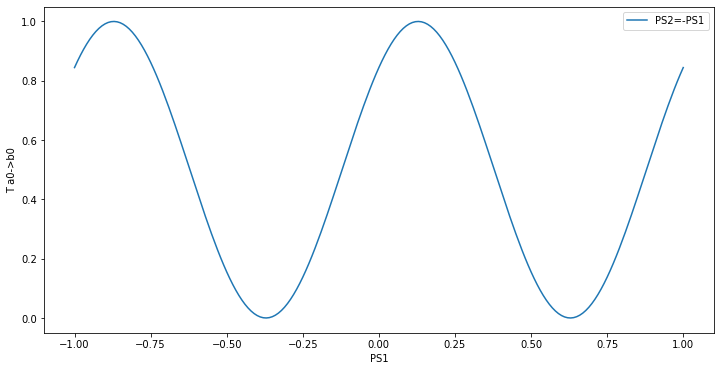

In [16]:
plt.figure(figsize=[12.0, 6.0])

T=MZM.solve(wl=1.55, PS1=np.linspace(-1.0,1.0,201), PS2=np.linspace(1.0,-1.0,201)).get_data('a0','b0')
print(T)
plt.plot(T['PS1'],T['T'],label='PS2=-PS1')

plt.xlabel('PS1')
plt.ylabel('T a0->b0')
plt.legend()

It is also possible to loop two parameters independently, by using the `np.meshgrid` command:

         wl  PS1   PS2         T     Phase           Amplitude
0      1.55 -1.0 -1.00  0.844483  1.216100  0.319159+0.861755j
1      1.55 -1.0 -0.98  0.821049  1.247516  0.287854+0.859179j
2      1.55 -1.0 -0.96  0.796347  1.278932  0.256772+0.854643j
3      1.55 -1.0 -0.94  0.770475  1.310348  0.226037+0.848164j
4      1.55 -1.0 -0.92  0.743537  1.341764  0.195769+0.839768j
...     ...  ...   ...       ...       ...                 ...
10196  1.55  1.0  0.92  0.923785  1.090437  0.444140+0.852364j
10197  1.55  1.0  0.94  0.906288  1.121853  0.413178+0.857655j
10198  1.55  1.0  0.96  0.887187  1.153269  0.381945+0.860991j
10199  1.55  1.0  0.98  0.866559  1.184684  0.350564+0.862359j
10200  1.55  1.0  1.00  0.844483  1.216100  0.319159+0.861755j

[10201 rows x 6 columns]


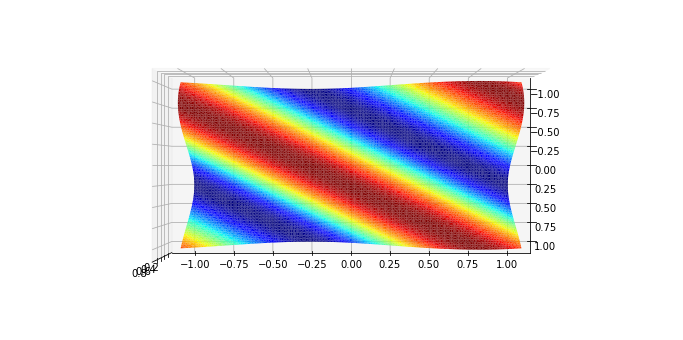

In [17]:
ps=np.linspace(-1.0,1.0,101)
P1,P2=np.meshgrid(ps,ps,indexing='ij')
T=MZM.solve(wl=1.55, PS1=P1, PS2=P2).get_data('a0','b0')
print(T)

fig = plt.figure(figsize=[12.0, 6.0])
ax = ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90.0, azim=0.0)
ax.plot_trisurf(T['PS1'],T['PS2'],T['T'], cmap='jet')

## Insight and debug
In order to explore the structure of a solver and to debug eventual mistakes, a few function are provided. Three are methods of the solver class:
- `show_structures()`: print a list of the structures inside the solver
- `show_connections()`: print a list of the internal connections between the structures in the solver
- `show_free_pins()`: print a list of the free pins of the structures inside the solver with the corresponding mapping to the external pins. All the pin showed here needs to me mapped for the code to work.
- `inspect()`: goes through the full hierarchy of the solver, printing for each layer the solvers and models contained in the top solver.

Here is an example of the output on the 'MZM_bal' solver. 

In [18]:
MZM_bal.show_structures()
MZM_bal.show_connections()
MZM_bal.show_free_pins()
MZM_bal.inspect()


Structures and pins of solver:                 Solver of MZM (id=140706896531184))
Structure (id=140706896547968) containing Model of beam-splitter with ratio 0.5 (id=140706896547912)
Structure (id=140706896548136) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706896548080)
Structure (id=140706896548304) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706896548248)
Structure (id=140706896548472) containing Model object (id=140706896548416) with pins: ['a0', 'b0']
Structure (id=140706896548640) containing Model object (id=140706896548584) with pins: ['a0', 'b0']
Structure (id=140706896548808) containing Model of beam-splitter with ratio 0.5 (id=140706896548752)

Connection of solver:                 Solver of MZM (id=140706896531184))
(Structure (id=140706896548136) containing Model of waveguide of lenght 10.000 and index 2.500 (id=140706896548080),    a0) <--> (Structure (id=140706896547968) containing Model of beam-splitter with ratio 0.5 

The `inspect` function could be quite useful to debug complex structures. Here for example is the output for `IQ_mod`

In [19]:
IQ_mod.inspect()

Solver of IQ_mod (id=140706896531128)
  Model of beam-splitter with ratio 0.5 (id=140706896549088)
  Solver of MZM (id=140706896549256)
    Model of beam-splitter with ratio 0.5 (id=140706896550544)
    Model of waveguide of lenght 10.000 and index 2.500 (id=140706896550488)
    Model of waveguide of lenght 10.000 and index 2.500 (id=140706896550264)
    Model object (id=140706896550432) with pins: ['a0', 'b0']
    Model object (id=140706896550320) with pins: ['a0', 'b0']
    Model of beam-splitter with ratio 0.5 (id=140706896550376)
  Solver of MZM (id=140706896550656)
    Model of beam-splitter with ratio 0.5 (id=140706896265400)
    Model of waveguide of lenght 10.000 and index 2.500 (id=140706896265344)
    Model of waveguide of lenght 10.000 and index 2.500 (id=140706896551776)
    Model object (id=140706896265288) with pins: ['a0', 'b0']
    Model object (id=140706896551832) with pins: ['a0', 'b0']
    Model of beam-splitter with ratio 0.5 (id=140706896551888)
  Model object (id=